In [45]:
%matplotlib inline

In [46]:
import pymap3d as pm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128


In [47]:
# Dado la rotación de la tierra, el objeto se "desplaza" en el cielo, por lo tanto se utiliza el
# ángulo horario y declinación para seguir su posición en el cielo

def calc_RR(H,dec):
    if np.isscalar(H):
        H = np.array([H])

    R = np.array([[np.sin(H), np.cos(H), np.zeros_like(H)],\
        [-np.sin(dec)*np.cos(H), np.sin(dec)*np.sin(H), np.cos(dec*np.ones_like(H))],\
        [np.cos(dec)*np.cos(H), -np.cos(dec)*np.sin(H), np.sin(dec*np.ones_like(H))]])

    return R

In [48]:
# Cambia la duración de la observación a X horas
horas_observacion = 1.0
observacion_grados = horas_observacion * 15.0

HA = np.arange(-0.5 * observacion_grados * (np.pi / 180.), 0.5 * observacion_grados * (np.pi / 180.), 0.1 * (np.pi / 180.))  # [radianes]
grados=45
dec = grados*np.pi/180.


In [49]:
# Coordenada de referencia (latitud, longitud, altura)
lat_ref = -41.463874
lon_ref = -72.920166
alt_ref = 100

# Coordenadas geodésicas (latitud, longitud, altura)
# En principio estas son el tipo de coordenadas que se envian desde los telefonos
coords_geodetic = [
    [-41.464183, -72.919694, 100],
    [-41.464507, -72.919898, 100],
    [-41.464263, -72.919739, 100],
    [-41.464304, -72.919764, 100],
    [-41.464342, -72.919789, 100],
    [-41.464387, -72.919819, 100],
    [-41.464424, -72.919843, 100],
    [-41.464469, -72.919870, 100],
    [-41.464507, -72.919898, 100]
]
coords_geodetic = np.array(coords_geodetic)
# Transformar coordenadas ECEF (X,Y,Z)
# https://github.com/JLBLine/simulating_interferometers/blob/master/Simulating_interferometers.ipynb
# Me base en este cueaderno para utilizar este tipo de coordenadas, desconozco si es el correcto
# ya que habla de coordenadas locales X, Y, Z y esto es lo más cercano que encontre luego de estar
# su buen tiempo buscando y leyendo información
ECEF_coords = []
for coord in coords_geodetic:
    x, y, z = pm.geodetic2ecef(coord[0], coord[1], coord[2])
    ECEF_coords.append([x, y, z])

ECEF_coords=np.array(ECEF_coords)
ECEF_coords

array([[ 1405906.62637861, -4575566.41883845, -4201258.33995358],
       [ 1405883.33683866, -4575548.64784484, -4201285.30591561],
       [ 1405901.30473607, -4575561.89918647, -4201264.99822819],
       [ 1405898.42267029, -4575559.63040073, -4201268.41059079],
       [ 1405895.60540603, -4575557.57250582, -4201271.57326641],
       [ 1405892.23765081, -4575555.14520617, -4201275.3185378 ],
       [ 1405889.52184815, -4575553.13306436, -4201278.39798124],
       [ 1405886.39367192, -4575550.63214341, -4201282.14324795],
       [ 1405883.33683866, -4575548.64784484, -4201285.30591561]])

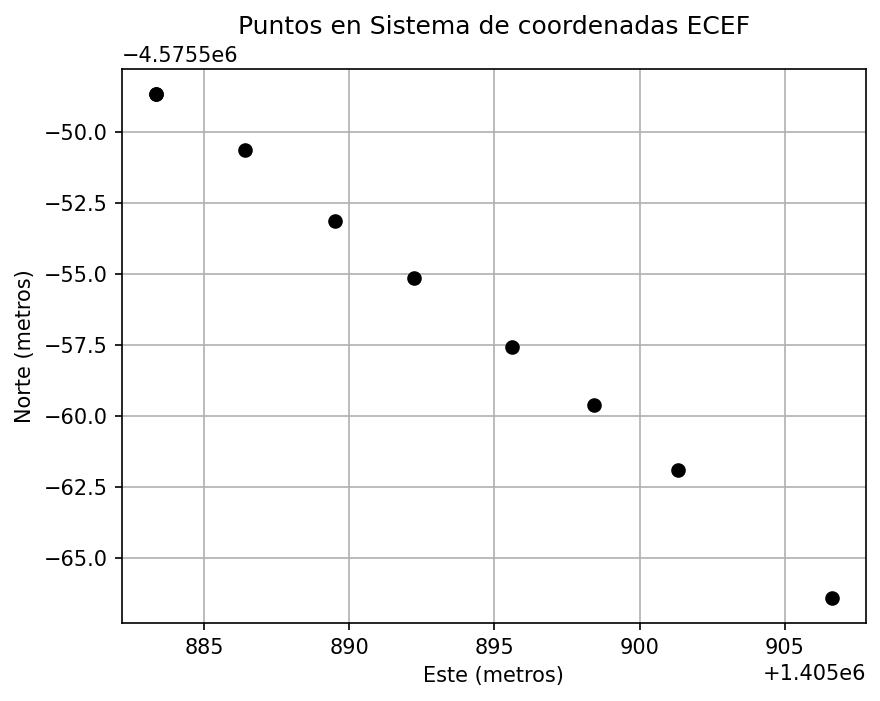

In [50]:
# Graficar puntos
plt.plot(ECEF_coords[:,0],ECEF_coords[:,1], 'ko')
plt.xlabel('Este (metros)')
plt.ylabel('Norte (metros)')
plt.title('Puntos en Sistema de coordenadas ECEF')
plt.grid(True)
plt.show()

In [51]:
XYZ_baselines = []                                                                  
for i in range(len(ECEF_coords)):                                                         
    for j in range(i+1,len(ECEF_coords)):
        XYZ_baselines.append(np.subtract(ECEF_coords[i], ECEF_coords[j])) # (u,v)
        XYZ_baselines.append(np.subtract(ECEF_coords[j], ECEF_coords[i])) # (-u,-v)     

XYZ_baselines = np.array(XYZ_baselines)
print("No. of baselines in (u,v) plane:", int(len(XYZ_baselines)/2))

No. of baselines in (u,v) plane: 36


In [52]:
R_complete = calc_RR(HA, dec)

In [53]:
R_complete

array([[[-0.13052619, -0.1287956 , -0.12706461, ...,  0.12533323,
          0.12706461,  0.1287956 ],
        [ 0.99144486,  0.99167116,  0.99189444, ...,  0.9921147 ,
          0.99189444,  0.99167116],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.70105738, -0.7012174 , -0.70137529, ..., -0.70153103,
         -0.70137529, -0.7012174 ],
        [-0.09229596, -0.09107224, -0.08984825, ...,  0.08862398,
          0.08984825,  0.09107224],
        [ 0.70710678,  0.70710678,  0.70710678, ...,  0.70710678,
          0.70710678,  0.70710678]],

       [[ 0.70105738,  0.7012174 ,  0.70137529, ...,  0.70153103,
          0.70137529,  0.7012174 ],
        [ 0.09229596,  0.09107224,  0.08984825, ..., -0.08862398,
         -0.08984825, -0.09107224],
        [ 0.70710678,  0.70710678,  0.70710678, ...,  0.70710678,
          0.70710678,  0.70710678]]])

In [54]:
UV_coverage = np.dot(R_complete.T, XYZ_baselines.T)

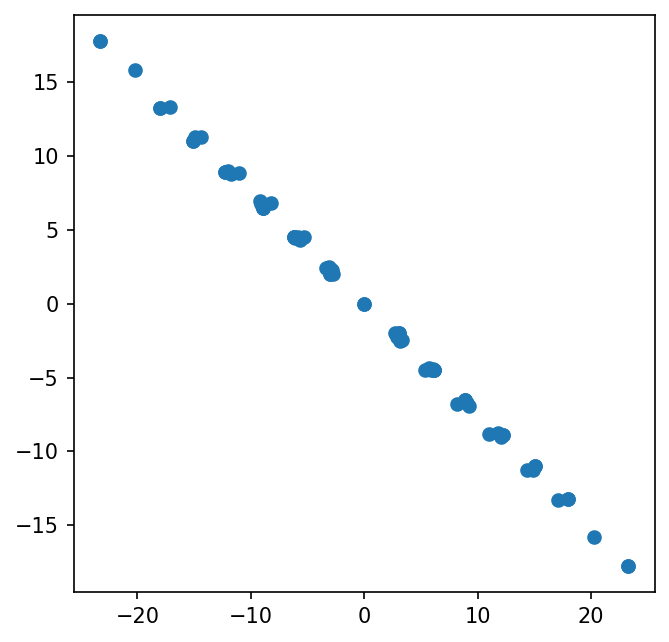

In [55]:
plt.figure(figsize=(5, 5))
plt.scatter(-XYZ_baselines[:,0], -XYZ_baselines[:,1],marker='o')

In [56]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

#x = np.arange(0, len(HA))
def animate(t):
    plt.cla()
    plt.scatter(UV_coverage[0:t,0,:],UV_coverage[0:t,1,:], c="black", marker=".")

matplotlib.animation.FuncAnimation(fig, animate, frames=len(HA))